In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from WARP.visualization import set_mplstyle
set_mplstyle()
from WARP.visualization import save_figure

import pickle

In [3]:
p = '/nrs/ahrensraverfish/hesselinkl/RAVERFISH/'
p2 = '/groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH/'

### Load data

#### Load fish data

In [4]:
from WARP.data_loading import load_WARP_data
from WARP.data_loading import filter_fish_data
from WARP.data_loading import add_subtypes_to_fish_data

fish_inspect = [59, 63, 71]

# fish_data = load_WARP_data(data_path=p+'data',
#                             filter_genes=['pitx2'], 
#                             fish_list=fish_inspect)

# fish_data = add_subtypes_to_fish_data(fish_data, ignore_genes_list=['cfos'])

# fish_data = filter_fish_data(fish_data, 
#                              filter_in_out_of_plane=True, 
#                              filter_nan_traces=True, 
#                              filter_zero_traces=True)

# with open(p + 'fish_data.pkl', 'wb') as f:
#     pickle.dump(fish_data, f)

with open(p + 'fish_data.pkl', 'rb') as f:
    fish_data = pickle.load(f)

#### Load precomputed LCD data

LCD data should be downloaded or computed using `/notebooks/calculate_LCD.ipynb`

In [6]:
import pickle
from tqdm.auto import tqdm

filter_genes = ['cx43', 'pitx2', 'cfos']

with open('/groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH/WARP/data/LCD_data_new.pkl', 'rb') as f:
    LCD_data = pickle.load(f)

with open('/groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH/WARP/data/LCD_data_time.pkl', 'rb') as f:
    LCD_data_time = pickle.load(f)

# with open('/groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH/WARP/LCD_data_min2500_max15000.pkl', 'rb') as f:
#     LCD_data_large = pickle.load(f)

for fish_n in tqdm(fish_inspect):
    for paradigm in LCD_data.keys():
        for gene in LCD_data[paradigm][fish_n].keys():
            try:
                LCD_data[paradigm][fish_n][gene]['observed_stats']['distance'][20]['vals_time_full'] = LCD_data_time[paradigm][fish_n][gene]['observed_stats']['distance'][20]['vals_time_full']
            except:
                pass
        #     LCD_data['visrap'][fish_n][gene]['observed_stats']['distance'][20]['vals_time_full'] = None
            # LCD_data['visrap'][fish_n].update(LCD_data_vglut_gad['visrap'][fish_n])

# with open('/groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH/WARP/LCD_data.pkl', 'wb') as f:
#     pickle.dump(LCD_data, f)

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
filter_genes = ['cx43', 'pitx2', 'cfos']

# Filter out genes
for paradigm in LCD_data.keys():
    for fish_n in fish_inspect:
        gene_list = list(LCD_data[paradigm][fish_n].keys())
        for gene in gene_list:
            if gene in filter_genes:
                del LCD_data[paradigm][fish_n][gene]

### Statistics

In [8]:
from WARP.lcd_statistics import compute_pvals
from WARP.lcd_statistics import merge_LCD_dicts

LCD_data = compute_pvals(
    LCD_data=LCD_data,
    fish_inspect=fish_inspect,
    alpha=0.05,
    alternative="two-sided",
    paradigms=None,
    mask_types=("distance", "region"),)


LCD_merged = merge_LCD_dicts(
    LCD_data,
    fish_inspect=fish_inspect,
    alpha=0.05,
    paradigms=None,              # or e.g. ['visrap']
    mask_types=("distance", "region"),
)

In [9]:
# Get values distributions for each gene
LCD_vals = {gene: d['observed_stats']['distance'][20]['vals'] for gene, d in LCD_merged['visrap'].items()}
LCD_vals = {gene: vals[~np.isnan(vals[:, 0])] for gene, vals in LCD_vals.items()}

LCD_pvals = {gene: d['p_vals']['distance'][20]['median']['corrected'] for gene, d in LCD_merged['visrap'].items()}

## Figure panels

### Figure 6B

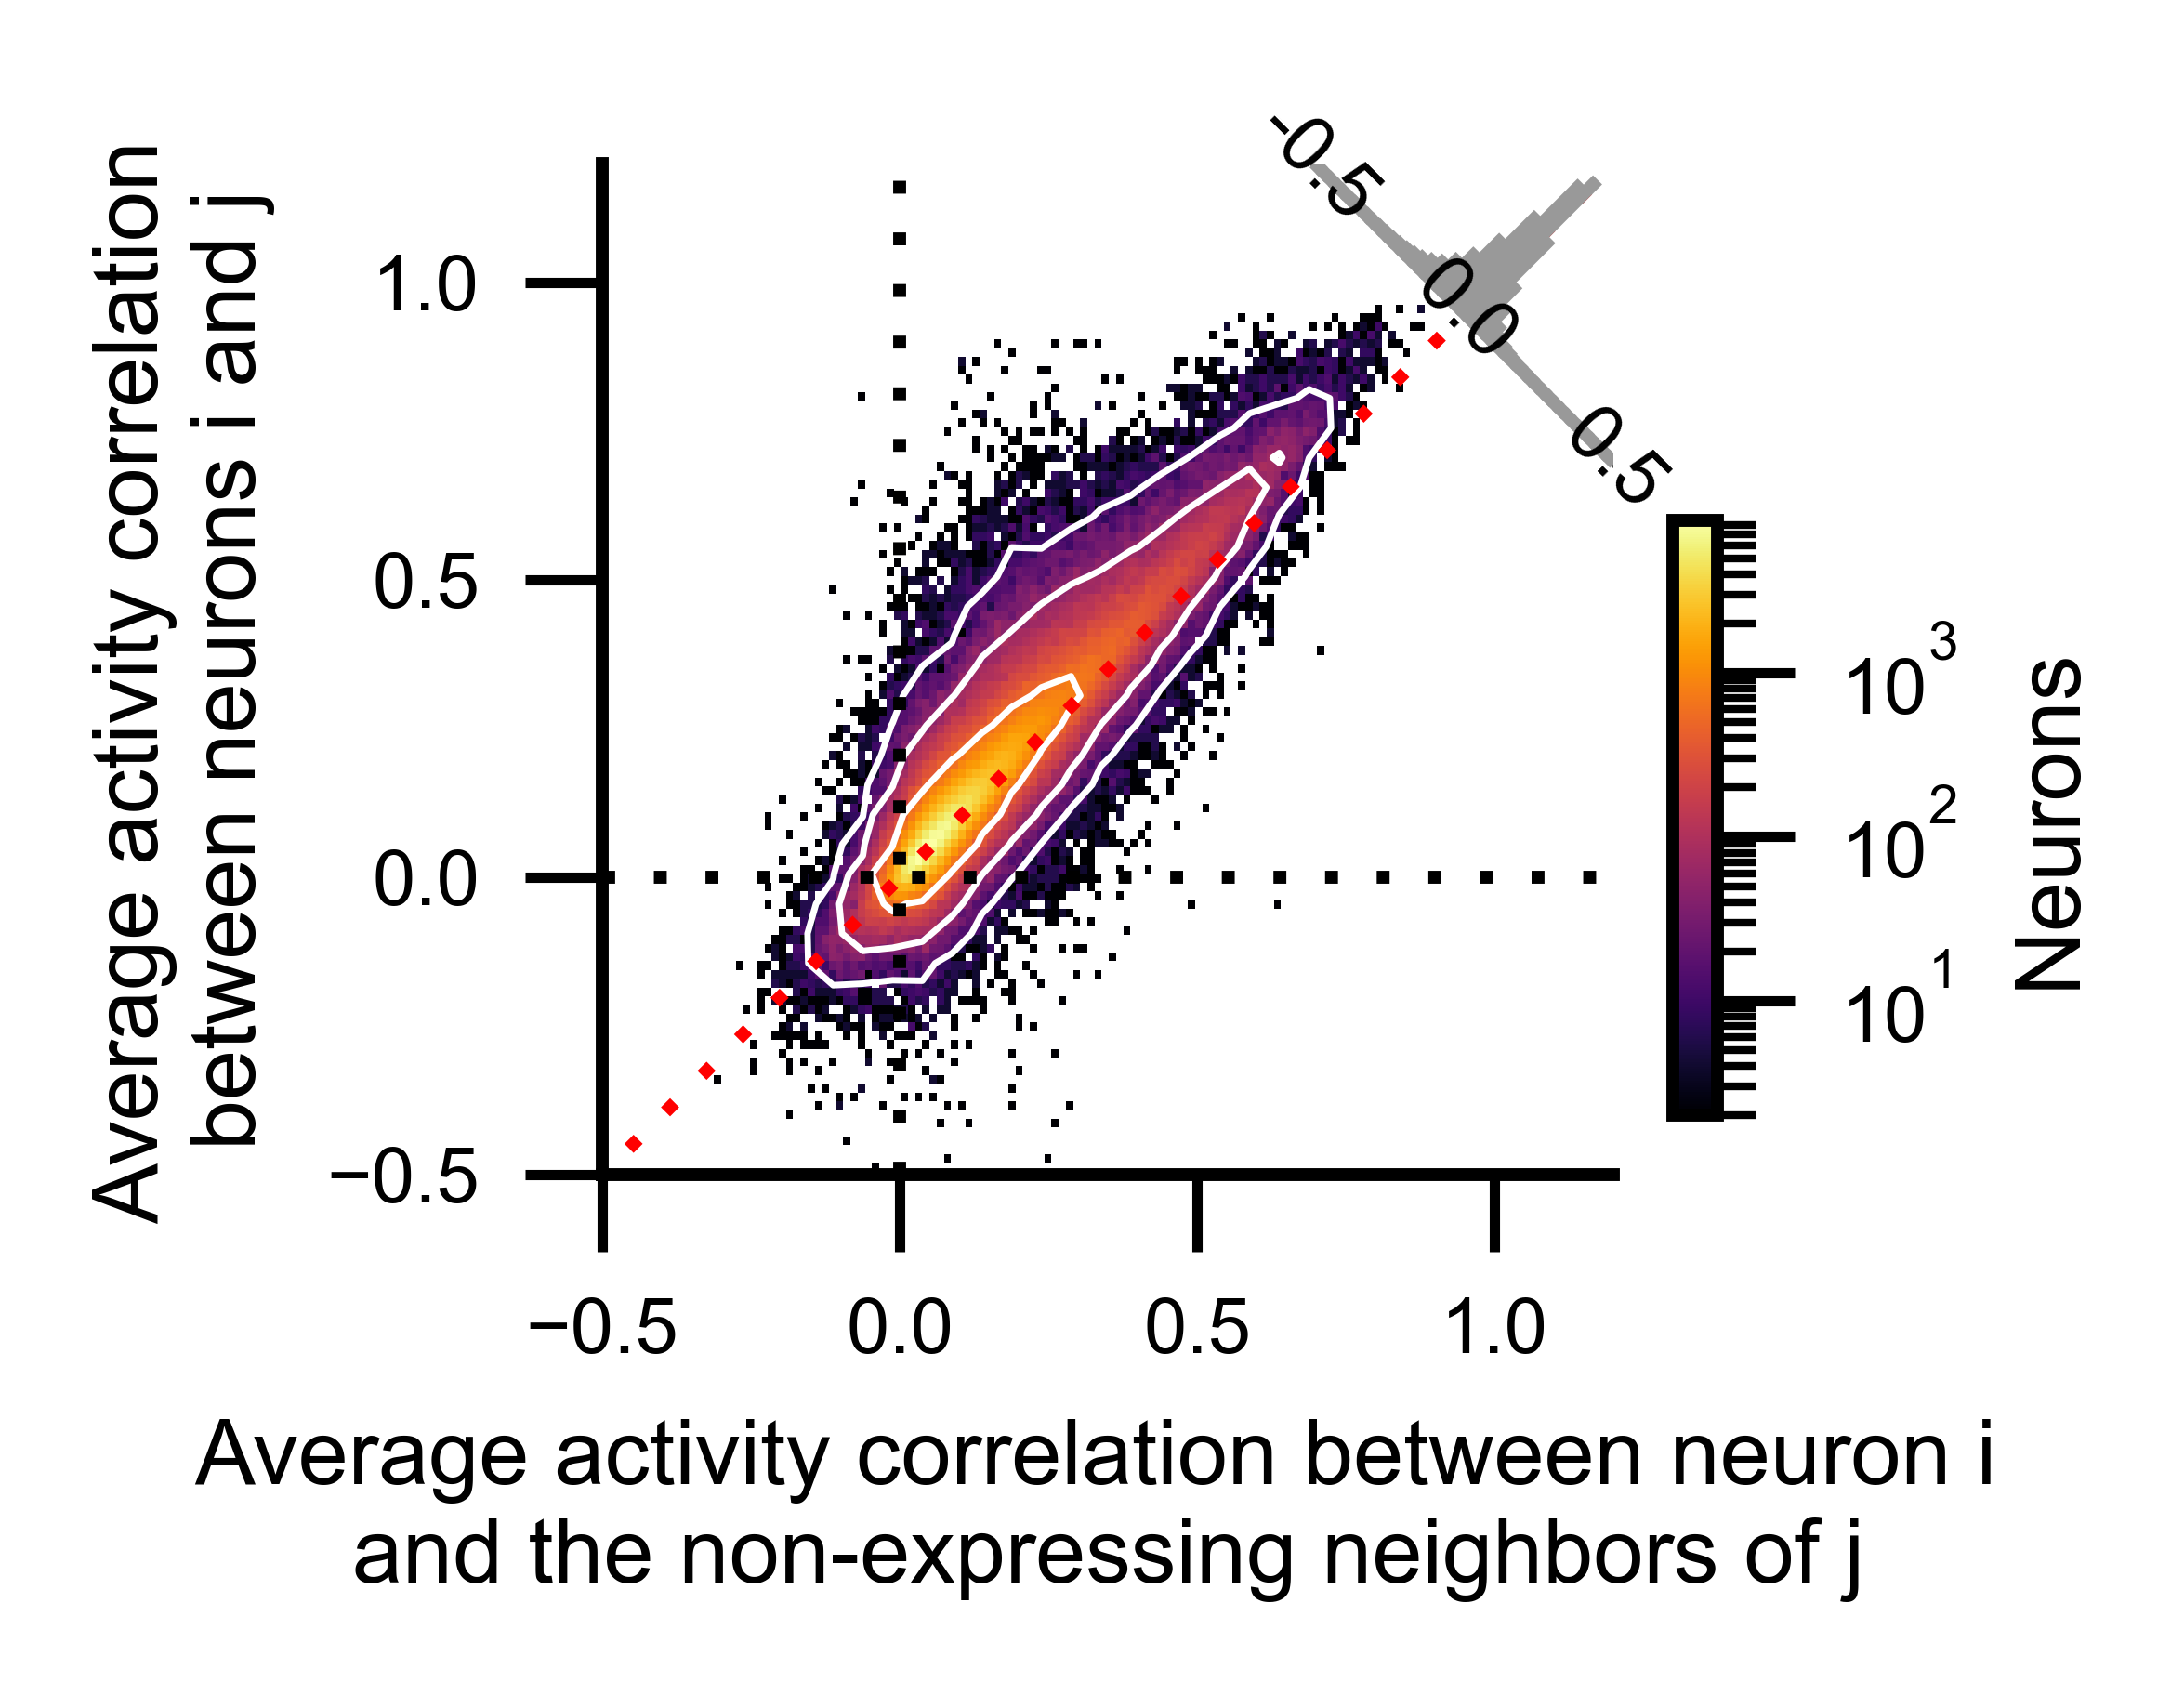

Succesfully saved figure to /groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH//WARP/figures/Figure_Panels/figure_6/


In [10]:
from WARP.visualization import plot_lcd_corr_scatter

fig = plot_lcd_corr_scatter(
    lcd_vals=LCD_vals,
    include_hist=True,
    contour=True,
    kde_step=0.05,
    bins_2d=100,
    cmap="inferno",
    contour_levels=(0.1, 0.5, 5.0),
    xlim=(-0.5, 1.2),
    ylim=(-0.5, 1.2),
    diff_range=(-0.5, 0.5),
    diff_bins=50,
    hist_extent_frac=0.18,
    show=True,
    xlabel="Average activity correlation between neuron i \nand the non-expressing neighbors of j",
    ylabel="Average activity correlation \nbetween neurons i and j"
)


save_figure(fig, 
            p2+"/WARP/figures/Figure_Panels/figure_6/",
            "Figure_6B",
            dpi=1000, 
            pad_inches=0.0)

### Figure 6C

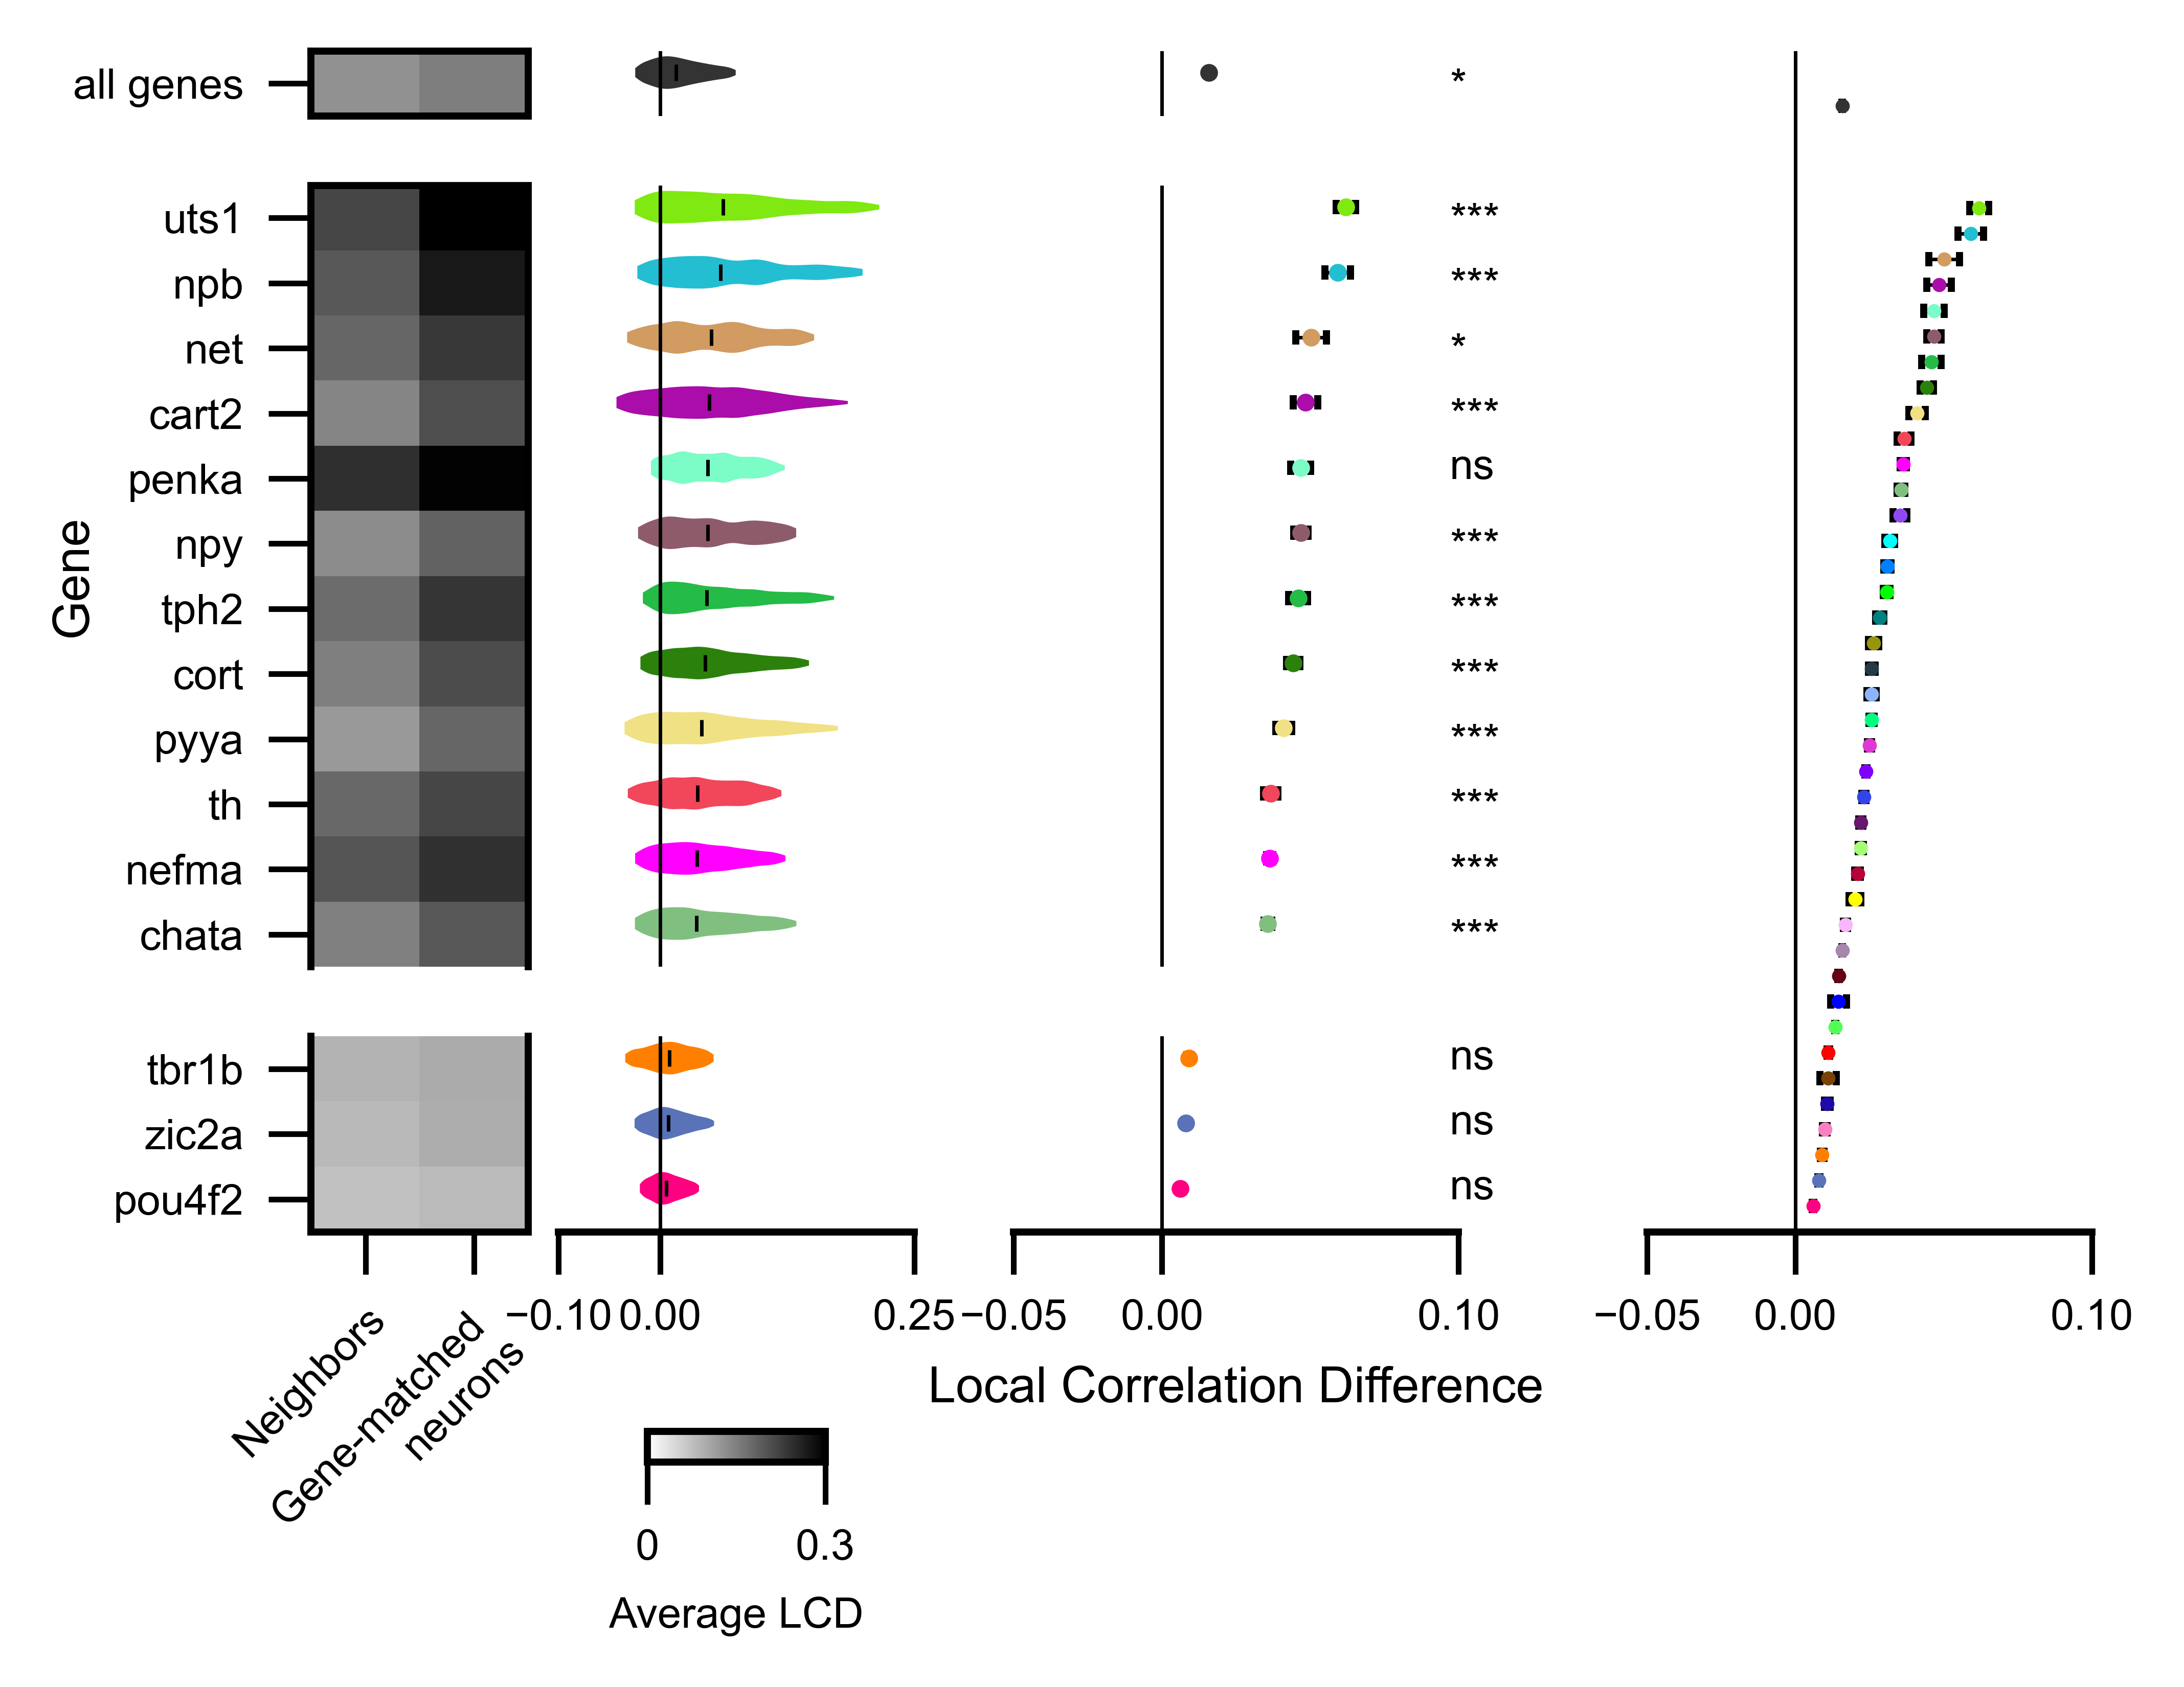

Succesfully saved figure to /groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH//WARP/figures/Figure_Panels/figure_6/


In [11]:
from WARP.visualization import plot_lcd_distributions
from WARP.visualization import make_cmap_dict

LCD_vals = {gene: v for gene, v in LCD_vals.items()}
sort_inds = np.argsort([np.nanmedian(v[:, 0]) for v in LCD_vals.values()])
LCD_color_dict = make_cmap_dict(LCD_data[paradigm][fish_n].keys(), sort_inds=sort_inds)

fig = plot_lcd_distributions(
    lcd_vals=LCD_vals,
    lcd_pvals=LCD_pvals,
    color_dict=LCD_color_dict,
    highN=12,
    lowN=3,
    include_pooled_row=True,
    show_all_genes=False,
    save_figure=False,
    save_dir='',
    save_name='',
    filter_percentile=15,
    bw_method=.2
)

save_figure(fig, 
            p2+"/WARP/figures/Figure_Panels/figure_6/",
            "Figure_6C",
            dpi=1000, 
            pad_inches=0.0)

In [12]:
a = .05
significant = [p < a for g, p in LCD_pvals.items()]

print(f'{sum(significant)-1}/{len(significant)-1} genes were significant under permutation') # remove 1 for the pooled entry

29/39 genes were significant under permutation


### Figure 6 Clustering

In [13]:
from WARP.lcd_clustering_utils import run_multiscale_lcd_clustering_across_genes
from WARP.lcd_clustering_utils import filter_supported_clusters
from WARP.lcd_clustering_utils import filter_supported_clusters_by_gene
from WARP.lcd_statistics import compute_cluster_pvals_all_clusters

# Run clustering across genes
cluster_dict, cluster_dict_by_gene = (
    run_multiscale_lcd_clustering_across_genes(
        LCD_data=LCD_data,
        fish_data=fish_data,
        fish_inspect=fish_inspect,
        distance_bin=20,
        target_cluster_size=10,
        n_neighbors=25,
        min_cluster_size=25,
        min_frac_per_fish=0.5,
        random_state=0,
        cluster_mode="leiden",
        mode_kwargs={"resolution": .1},  # optional; omit to use heuristic search
    )
)


# Compute cluster p-values using the precomputed neuron-wise permutations
cluster_dict, cluster_pooled_pval = compute_cluster_pvals_all_clusters(
    cluster_dict=cluster_dict,
    LCD_data=LCD_data,
    fish_data=fish_data,
    fish_inspect=fish_inspect,
    stim_keys=["random", "visrap"],
    mask_type="distance",
    mask=20,
    alternative="two-sided",
    center=None,
    alpha=0.05,
)


cluster_dict_supported = filter_supported_clusters(cluster_dict)
clusters_by_gene_supported = filter_supported_clusters_by_gene(cluster_dict_by_gene)

print("Supported clusters:", len(cluster_dict_supported))

Running LCD clustering across genes:   0%|          | 0/40 [00:00<?, ?it/s]

Skipping gene pooled: No neurons found for gene pooled in the specified fish.
Supported clusters: 207


In [14]:
from WARP.visualization import compute_lcd_color_dict
from WARP.visualization import plot_lcd_distributions

highN = 12
lowN = 3

color_name_order_dict = compute_lcd_color_dict(
    cluster_dict=cluster_dict_supported,
    highN=highN,
    lowN=lowN,
    color_mode="discrete",      # or "median_highlow", "median_all", "dict"
    median_cmap="coolwarm",
    base_color_dict=None,       # or your gene color map if color_mode="dict"
    stim_key='visrap'
)

### Figure 6D

Succesfully saved figure to /groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH//WARP/figures/Figure_Panels/figure_6/


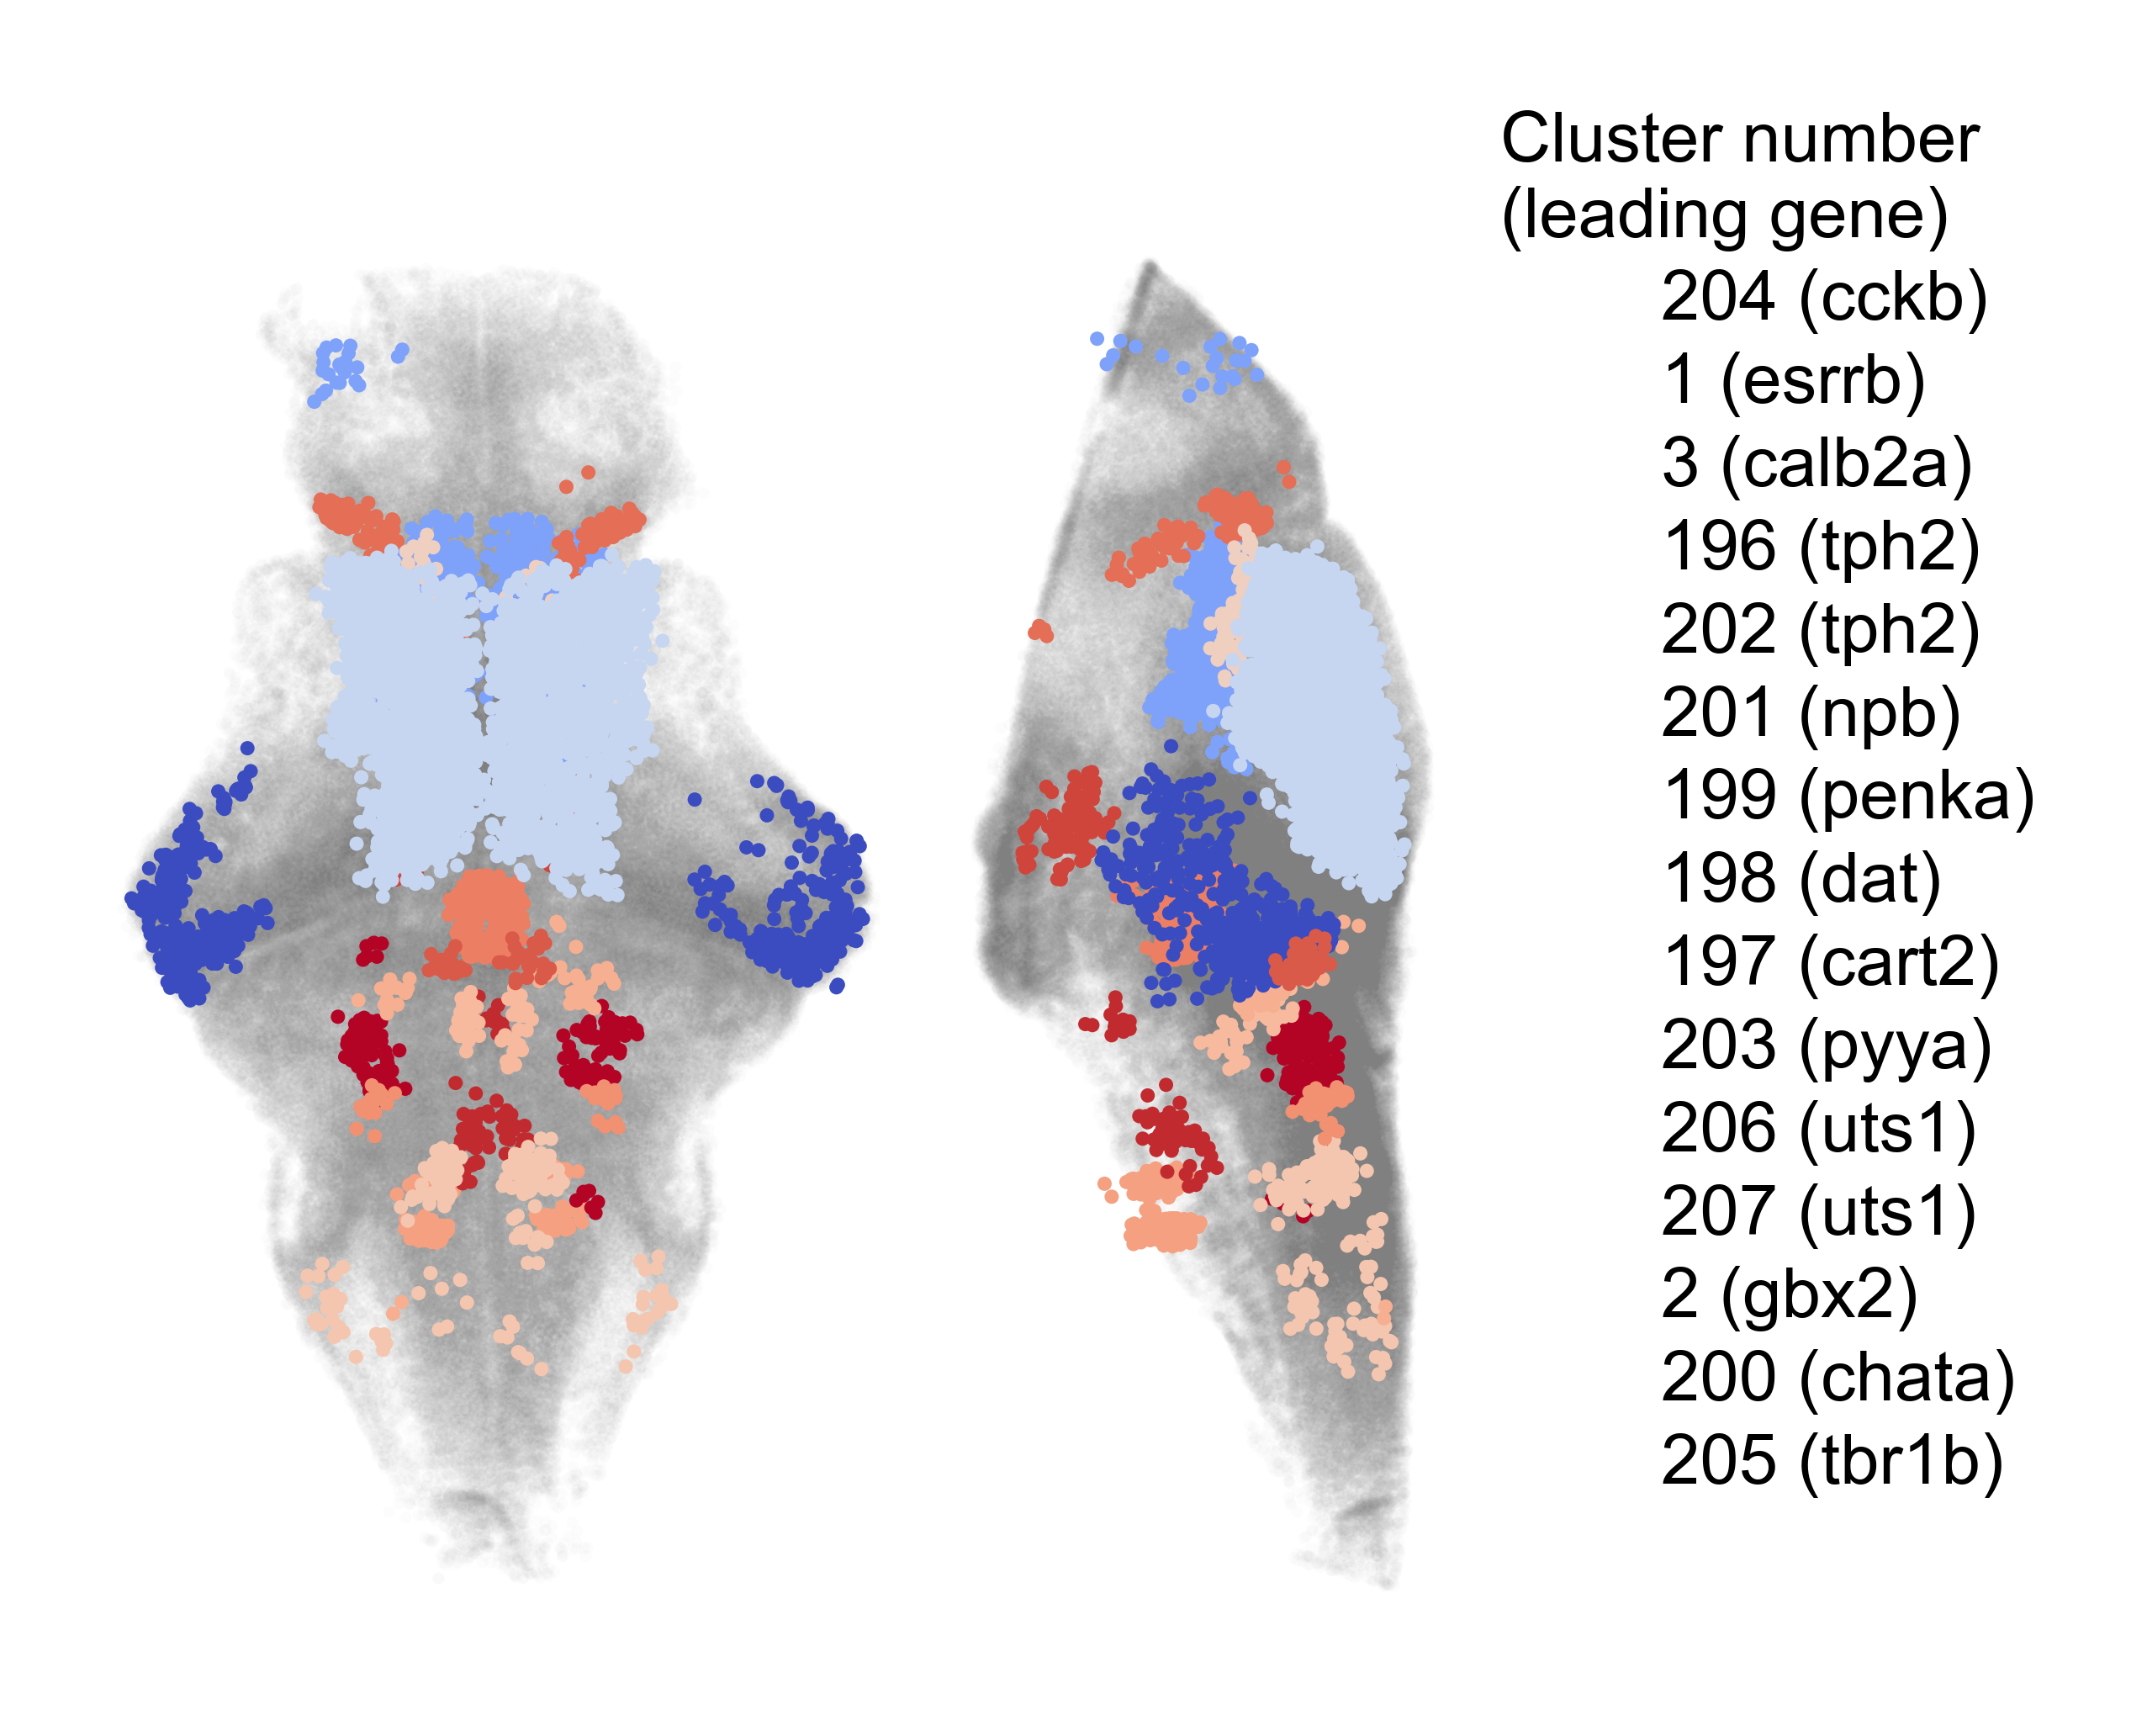

In [15]:
from WARP.visualization import plot_extreme_clusters_brain_map

cell_centers_all = fish_data[63]['cell_centers_data']['cell_centers_zb']

fig_ext, axes_ext = plot_extreme_clusters_brain_map(
    cell_centers_all=cell_centers_all,
    cluster_dict=cluster_dict_supported,
    color_dict=color_name_order_dict,
    which="both",
    fill_mode="solid",
    proj_axes=((1, 2), (0, 2)), 
    s=3,
    sort_mode='by_cluster_value', 
    alpha_inner=1,
    alpha_outer=0,
    alpha_bg=0.025,
    sort_ascending=True,
    stim_key='visrap'
)

save_figure(fig_ext, 
            p2+"/WARP/figures/Figure_Panels/figure_6/",
            "Figure_6D",
            dpi=1000, 
            pad_inches=0)

### Figure 6E

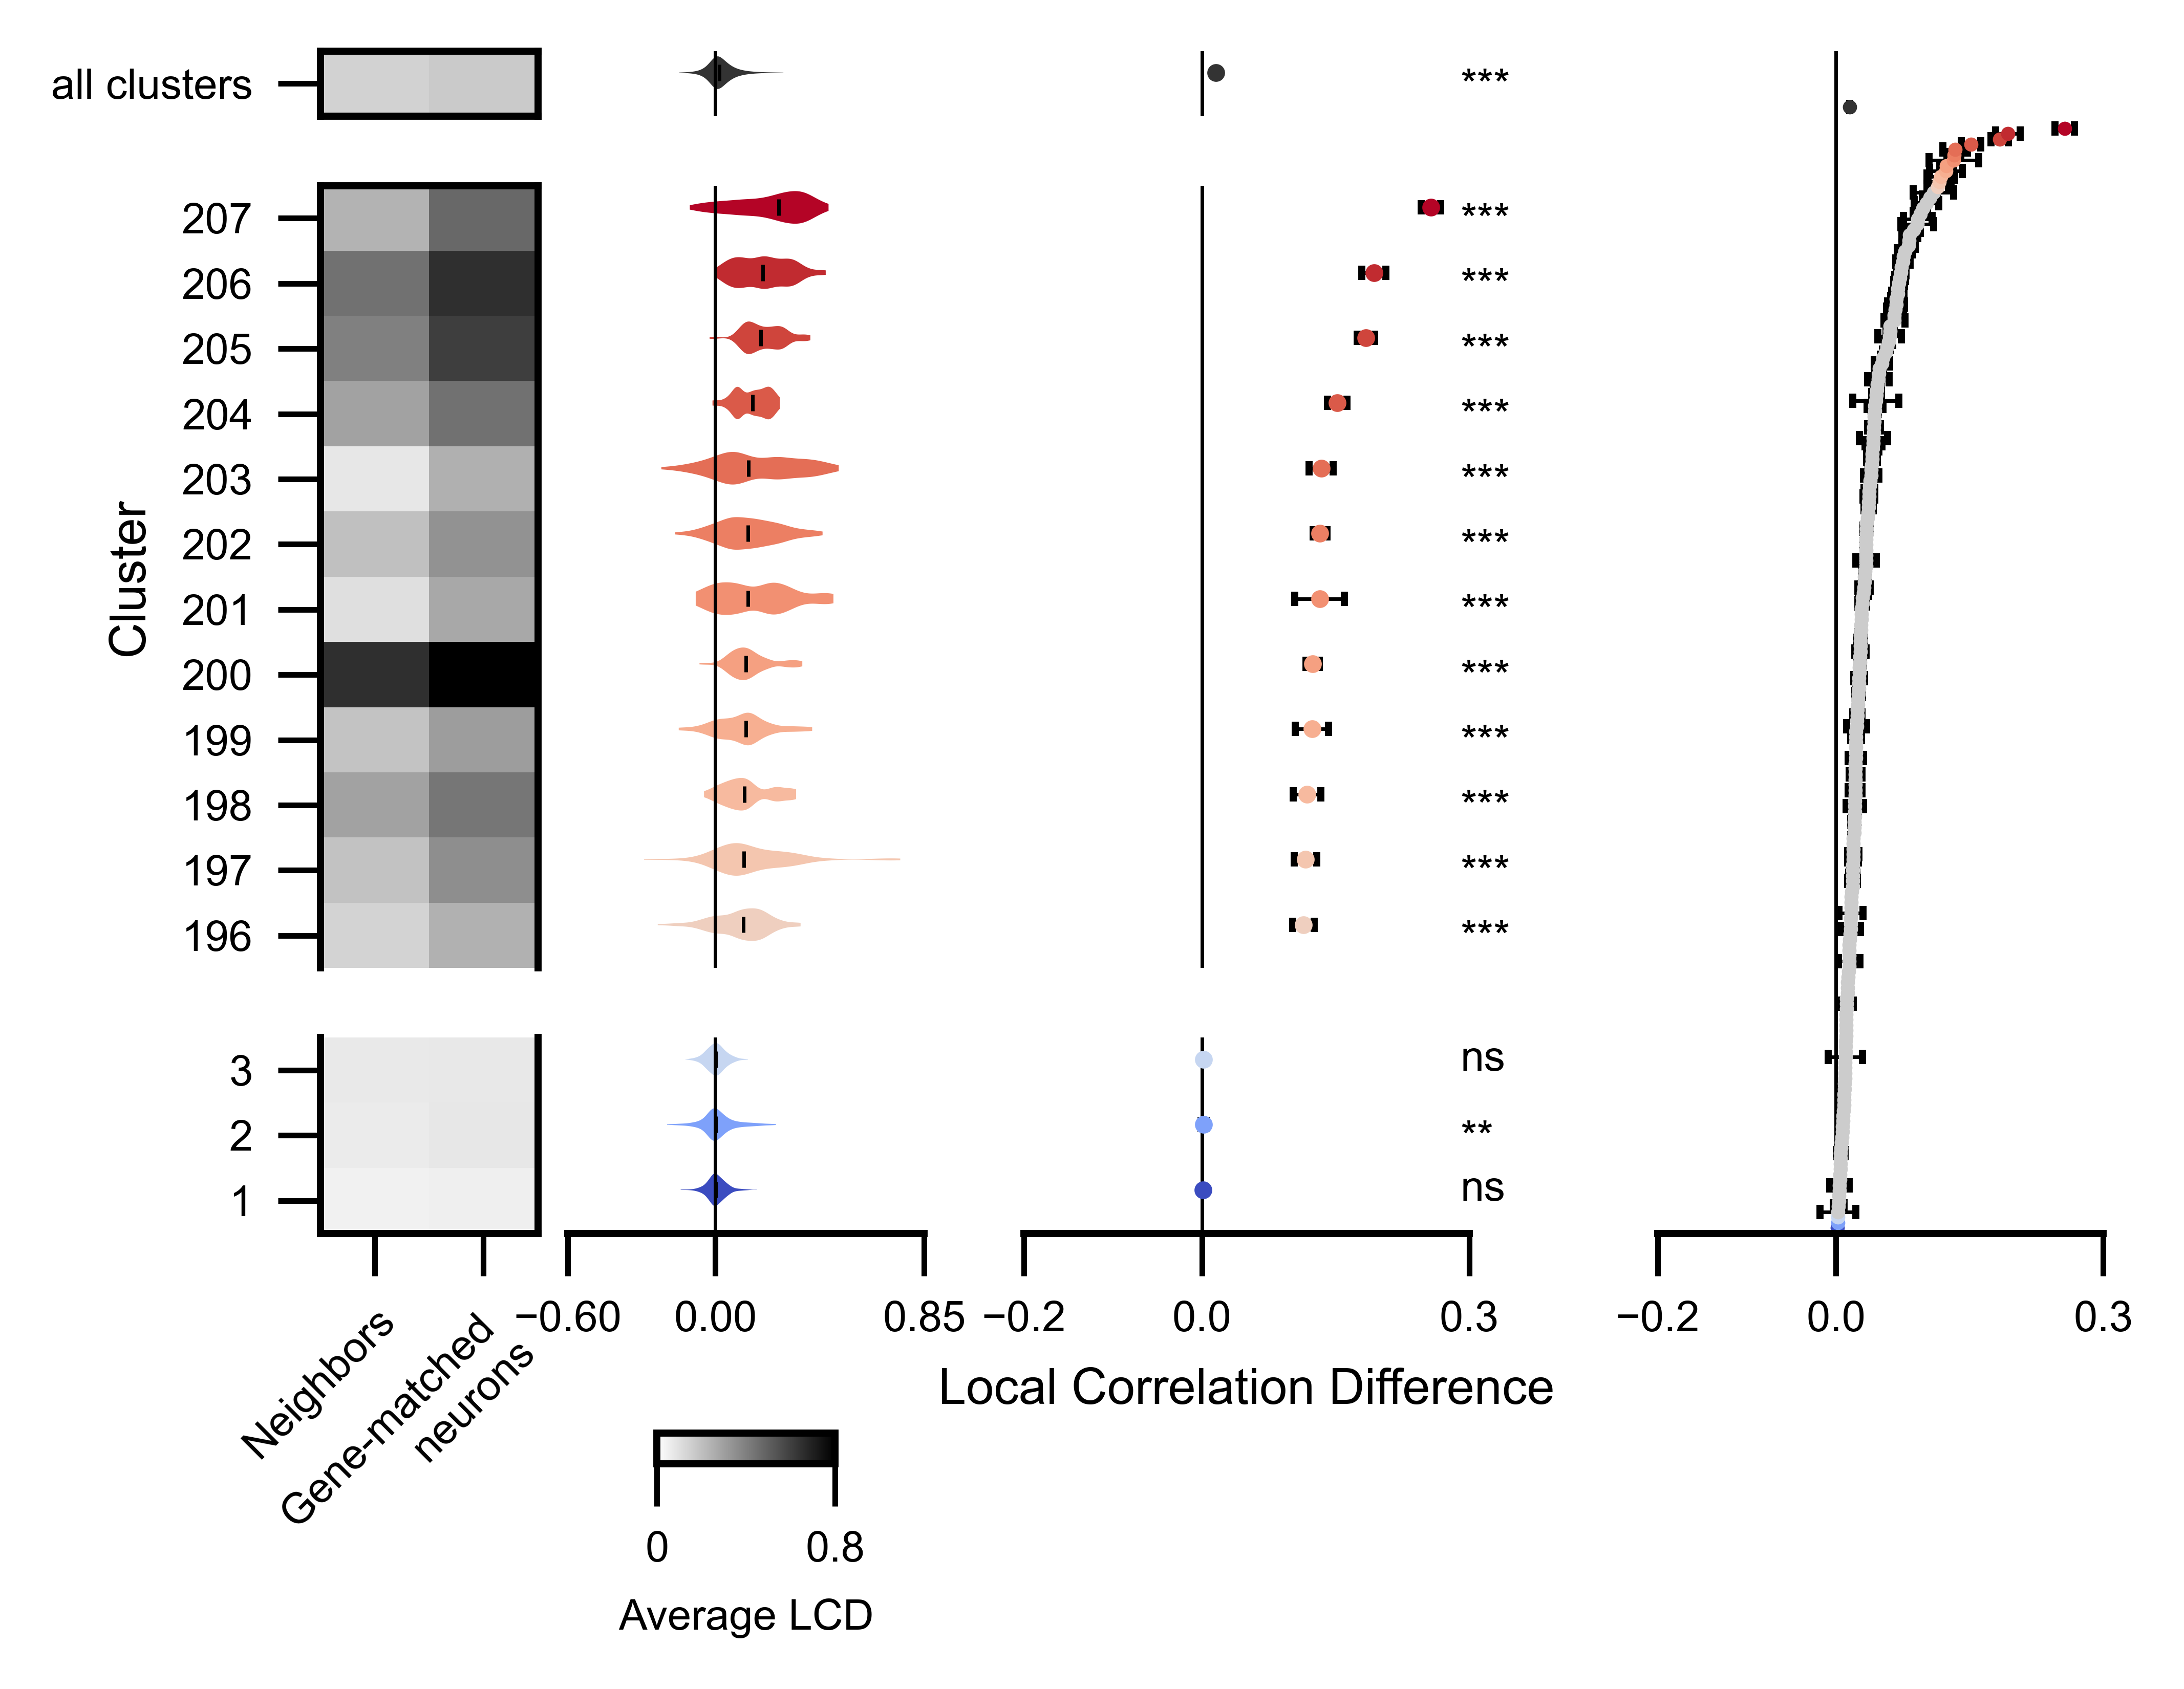

Succesfully saved figure to /groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH//WARP/figures/Figure_Panels/figure_6/


In [16]:
lcd_pvals = {k: v['cluster_pval']['visrap']['p_value_corr'] for k, v in cluster_dict_supported.items()}
lcd_pvals['pooled'] = cluster_pooled_pval['visrap']['p_value_corr']

fig = plot_lcd_distributions(
    lcd_vals={k: v['lcd_vals']["visrap"] for k, v in cluster_dict_supported.items()},
    lcd_pvals=lcd_pvals,
    color_dict={k: v['color'] for k, v in color_name_order_dict.items()},
    name_dict={k: v['name'].split(' ')[0] for k, v in color_name_order_dict.items()},
    highN=highN,
    lowN=lowN,
    include_pooled_row=True,
    filter_percentile=.5,
    bw_method=.3,
    ylabel="Cluster", 
)

save_figure(fig, 
            p2+"/WARP/figures/Figure_Panels/figure_6/",
            "Figure_6E",
            dpi=1000, 
            pad_inches=0)

### Figure 6F

/groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH/WARP/WARP/visualization.py:2828: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Succesfully saved figure to /groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH//WARP/figures/Figure_Panels/figure_6/


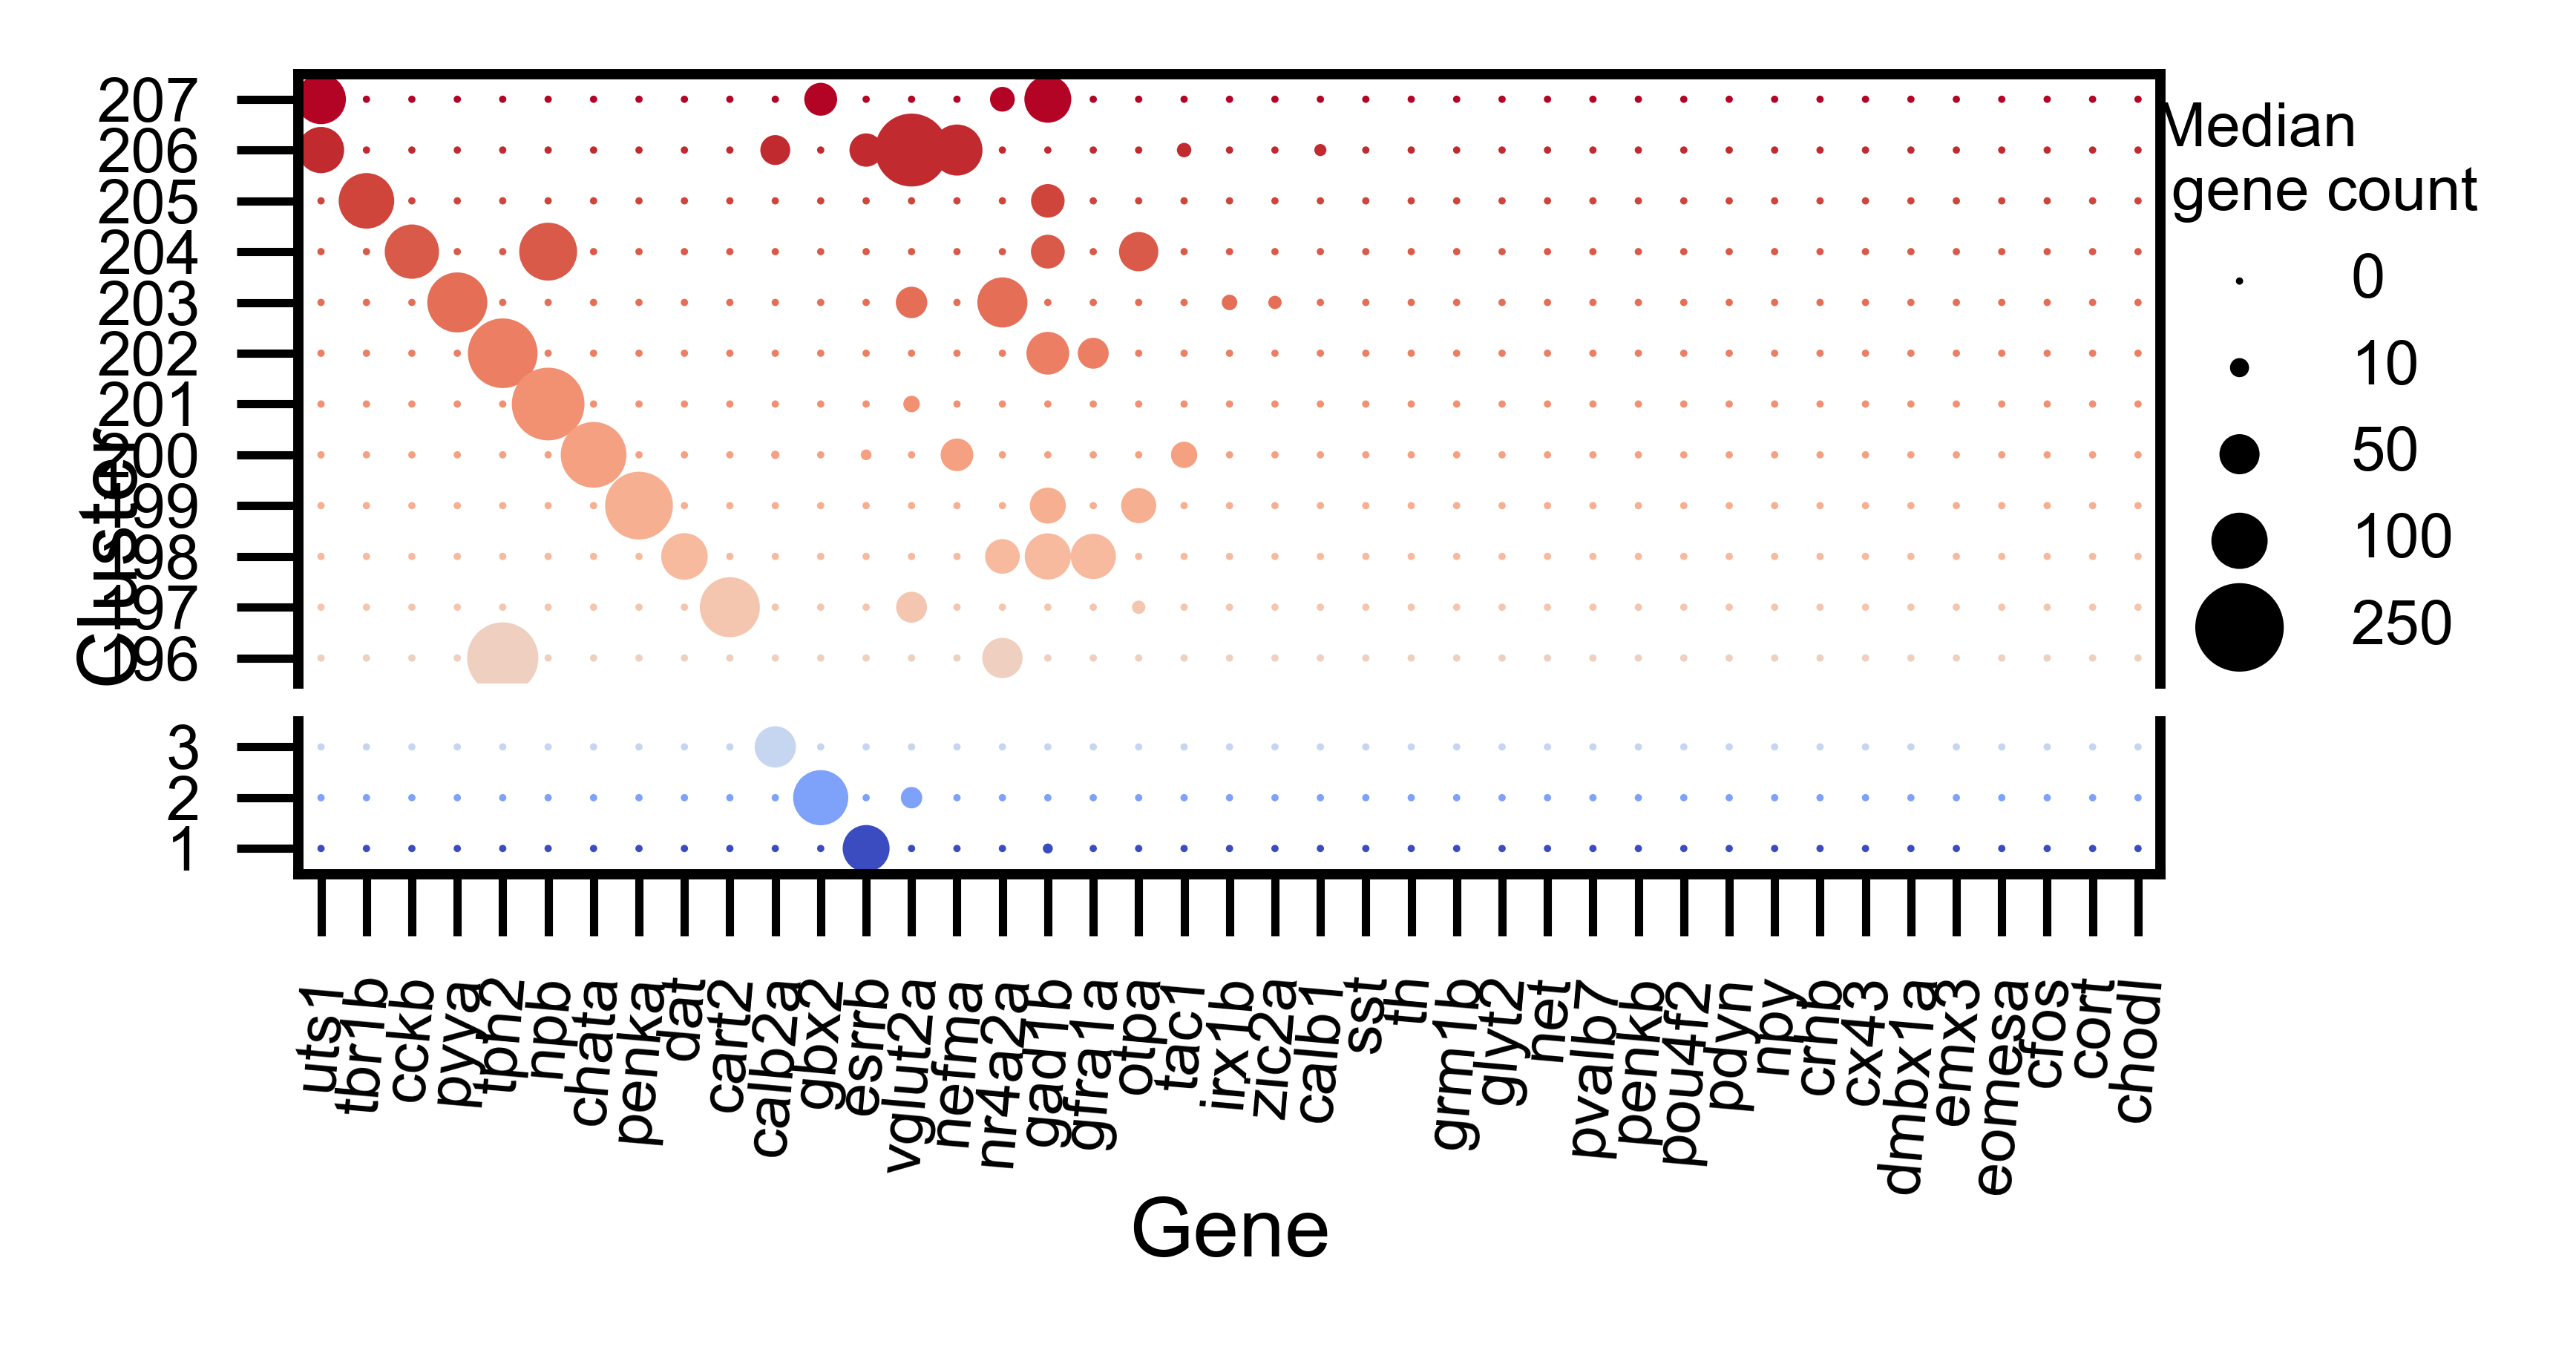

In [17]:
from WARP.visualization import plot_cluster_gene_counts_scatter

fig = plot_cluster_gene_counts_scatter(
    cluster_dict=cluster_dict_supported,
    color_dict=color_name_order_dict,
    gene_names=fish_data[fish_inspect[0]]["gene_data"]["gene_names"],
    which="both",
    min_cells_per_cluster=5,
    legend_display_values=(0, 10, 50, 100, 250),
    stim_key="visrap"
)

save_figure(fig, 
            p2+"/WARP/figures/Figure_Panels/figure_6/",
            "Figure_6F",
            dpi=1000, 
            pad_inches=0)

### Figure 6G

In [18]:
from WARP.lcd_clustering_utils import compute_cluster_neighbor_traces

neighbor_traces = compute_cluster_neighbor_traces(
    cluster_dict=cluster_dict_supported,
    fish_data=fish_data,
    neighbor_radius=15,
)

/groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH/WARP/WARP/visualization.py:3289: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Succesfully saved figure to /groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH//WARP/figures/Figure_Panels/figure_6/


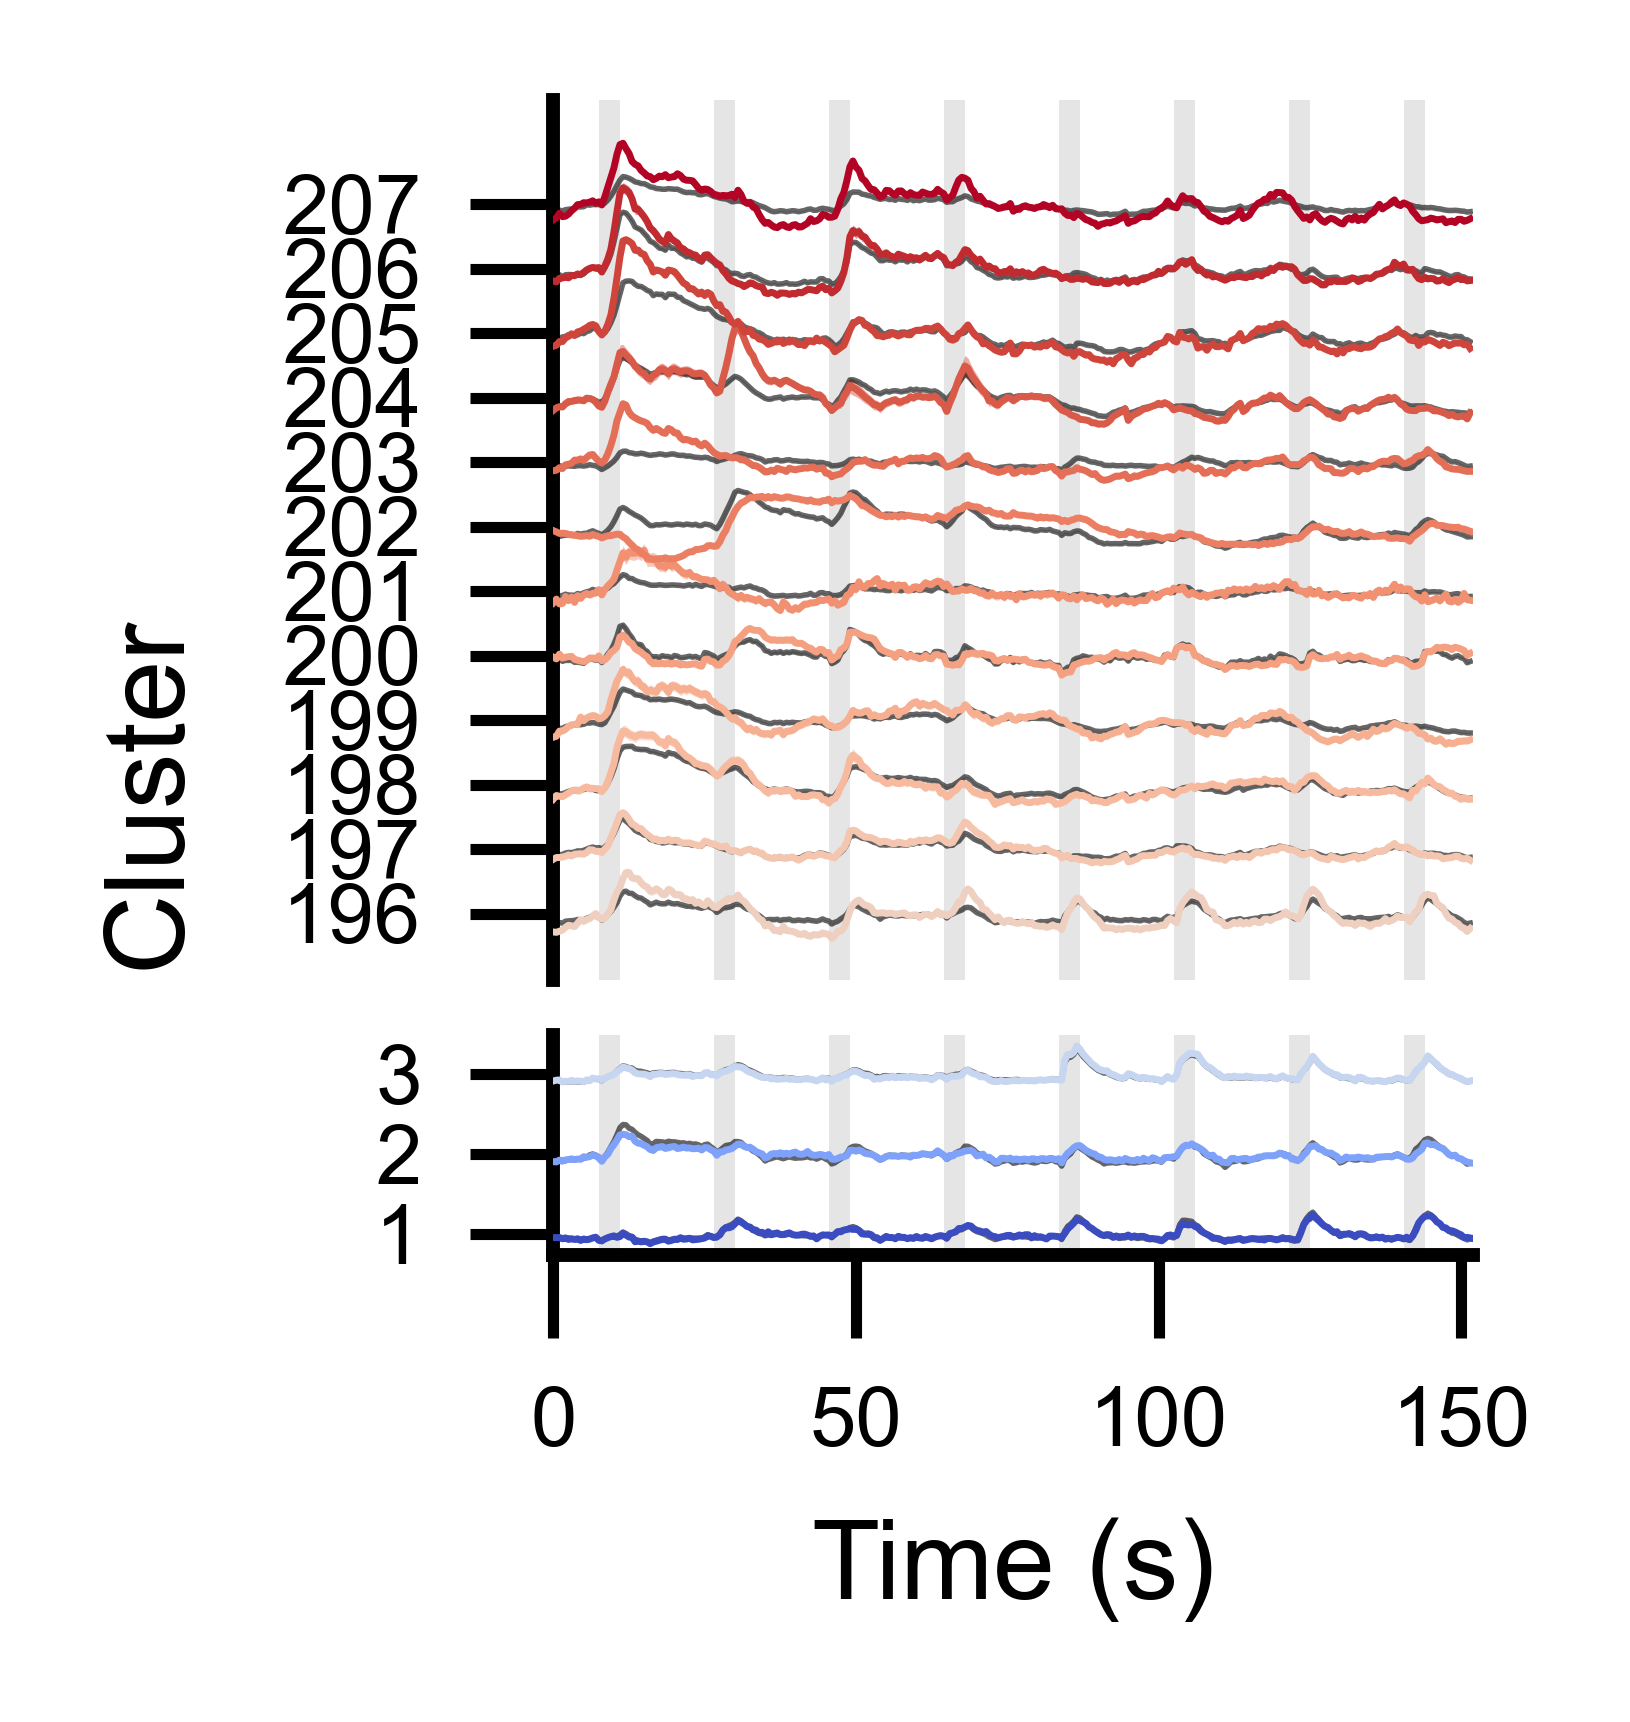

In [19]:
from WARP.visualization import plot_cluster_stim_responses

fig = plot_cluster_stim_responses(
    cluster_dict=cluster_dict_supported,
    color_dict=color_name_order_dict,
    which="both",
    plot_neighbors=True,
    plot_difference=False,
    neighbor_traces=neighbor_traces,
    offset_step=1.3,
    figsize=(1.35, 1.5),
    stim_key="visrap",
    use_order_label=False
)

save_figure(fig, 
            p2+"/WARP/figures/Figure_Panels/figure_6/",
            "Figure_6G",
            dpi=1000, 
            pad_inches=0)

### Figure 6H

Two-sided Wilcoxon Signed Rank Test. all genes, p<ε; npb, 1.670e-07; net, 4.986e-03; uts1, 4.394e-20; th, 2.653e-14; penka, 2.045e-09; cart2, 4.641e-08; tph2, 2.780e-18; npy, 7.118e-08; glyt2, 1.829e-44; otpa, 1.692e-152; nefma, 7.009e-53; grm1b, 7.440e-49; chata, 6.204e-28; crhb, 4.250e-06; penkb, 1.524e-32; esrrb, 3.026e-68; nr4a2a, 1.275e-58; gad1b, p<ε; gfra1a, 6.295e-40; irx1b, 8.747e-17; tac1, 2.378e-23; pvalb7, 1.765e-38; all genes, p<ε; pooled, p<ε; cort, 7.391e-04; pyya, 1.759e-05; cckb, 5.534e-15; sst, 4.207e-06; dmbx1a, 4.446e-22; vglut2a, p<ε; eomesa, 2.088e-07; calb1, 4.264e-04; gbx2, 9.936e-04; dat, 1.527e-03; zic2a, 1.673e-46; pou4f2, 9.836e-39; tbr1b, 2.220e-07; calb2a, 9.876e-12; pdyn, 6.232e-03; chodl, 1.725e-01; emx3, 1.031e-03;

Two-sided Wilcoxon Signed Rank Test, Bonferroni-corrected. all genes, p<ε; npb, 6.847e-06; net, 2.044e-01; uts1, 1.802e-18; th, 1.088e-12; penka, 8.385e-08; cart2, 1.903e-06; tph2, 1.140e-16; npy, 2.919e-06; glyt2, 7.500e-43; otpa, 6.938e-15

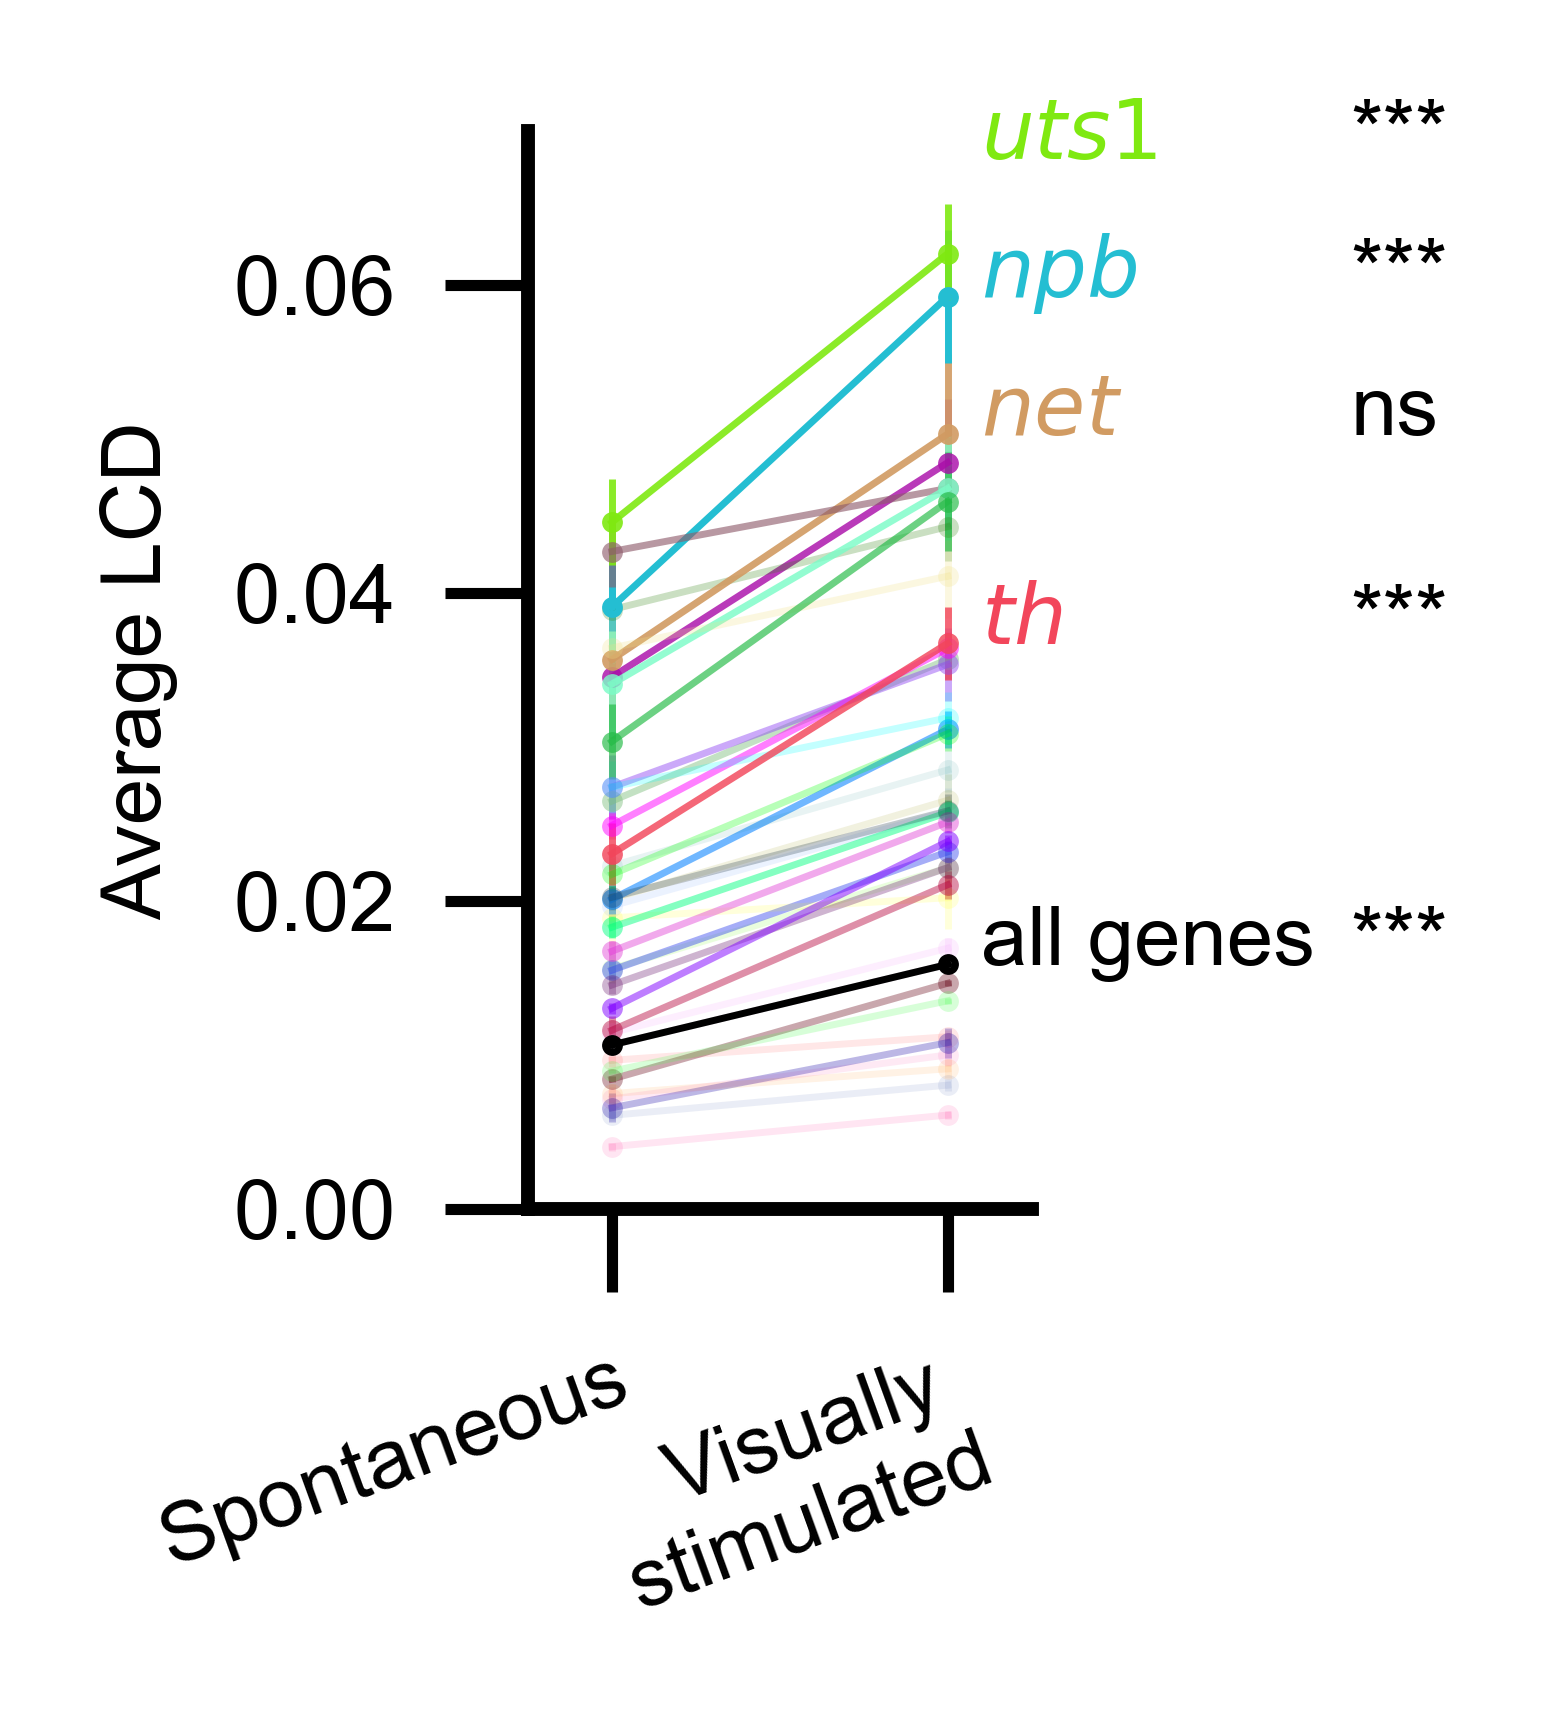

In [20]:
from WARP.lcd_utils import compute_lcd_spontaneous_vs_visstim_stats
from WARP.visualization import plot_lcd_spontaneous_vs_visstim

stats = compute_lcd_spontaneous_vs_visstim_stats(
    LCD_data,
    fish_inspect=fish_inspect,
    mask_type="distance",
    mask=20,
    spont_key="random",
    engaged_key="visrap",
)

fig = plot_lcd_spontaneous_vs_visstim(
    stats,
    N_text=5,
    cmap_dict=LCD_color_dict,
)

save_figure(fig, 
            p2+"/WARP/figures/Figure_Panels/figure_6/",
            "Figure_6H",
            dpi=1000, 
            pad_inches=0)

In [21]:
a = .05
significant = stats['p_vals_bonferroni'][:-1] < a # Remove all genes

print(f'{sum(significant)}/{len(significant)} genes significantly increased under Wilcoxon signed rank test + bonferroni correction')

36/40 genes significantly increased under Wilcoxon signed rank test + bonferroni correction
